In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import librosa, IPython
import librosa.display as lplt

import IPython.display as ipd
from IPython.display import Audio

## 1. Load And Arrange The Data

The data set is included a .csv file with the extracted features:

In [2]:
df = pd.read_csv('features_30_sec.csv')

#### Check If The Data Is Balanced:

Class Balance:

In [3]:
df.label.value_counts().reset_index()

,label,count
0,blues,100
1,classical,100
2,country,100
3,disco,100
4,hiphop,100
5,jazz,100
6,metal,100
7,pop,100
8,reggae,100
9,rock,100


We have exactly 100 samples out of each class.

In [4]:
data = df.iloc[:,1:59];

## 2. Pre-Processing:

Scale the data to prevent feature imbalances:

In [277]:
data_scaler = MaxAbsScaler().fit(data);

In [278]:
scaled_data = data_scaler.transform(data);

In [279]:
scaled_data.astype('float64', casting = 'same_kind');

### Data Augmentation

will be implemented in the "Fighting Overfitting" scripts

## 3. Data Visualization:

Load samples from the data set

In [8]:
hiphop_sample, hiphop_sr = librosa.load('hiphop_sample.wav', duration = 7.0);
rock_sample, rock_sr = librosa.load('rock_sample.wav', duration = 7.0);

Play the samples

In [9]:
print("Hip Hop Sample:");
ipd.Audio(hiphop_sample,rate = hiphop_sr)

Hip Hop Sample:


In [10]:
print("Rock Sample:");
ipd.Audio(rock_sample,rate = rock_sr)

Rock Sample:


Plot the waveform of the sample:

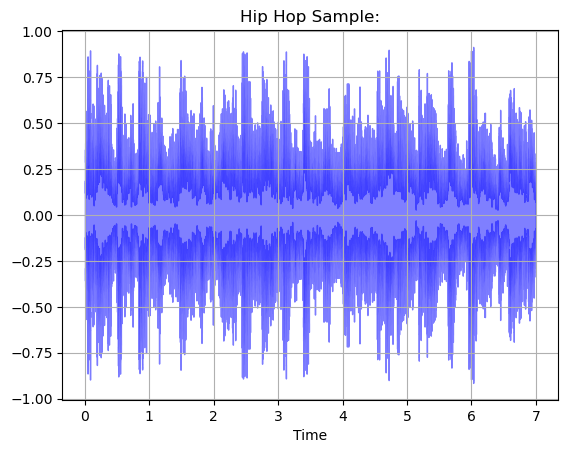

In [17]:
plt.figure()
librosa.display.waveshow(hiphop_sample, color = "blue", alpha = 0.5)
plt.title("Hip Hop Sample:");
plt.grid()
plt.show()

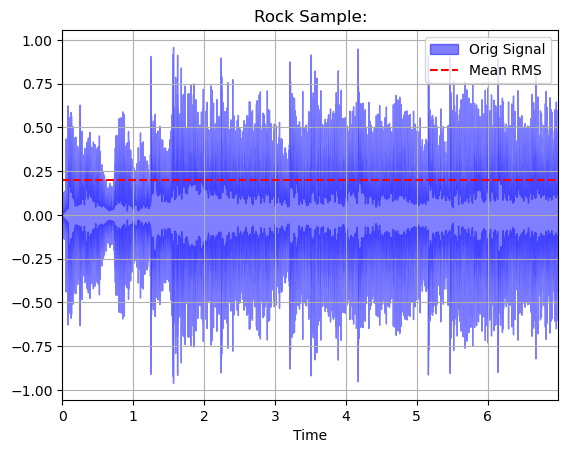

In [228]:
plt.figure()
librosa.display.waveshow(rock_sample, color = "blue", alpha = 0.5,label = "Orig Signal")
rms_ = librosa.feature.rms(y=rock_sample)
plt.axhline(y=rms_[0].mean(), color='r', linestyle='--', label = "Mean RMS")
plt.legend()
plt.title("Rock Sample:")
plt.grid()

plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

### Feature Visualization: MFCC's, Chromagrams, Etc.

#### Seperation of Harmonic and Percussive Signals

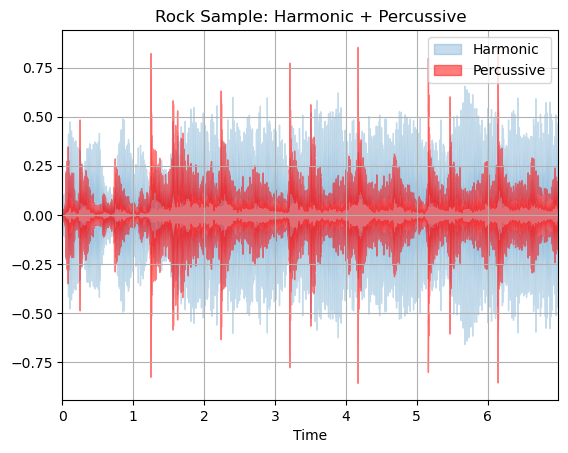

In [229]:
y1_harmonic, y1_percussive = librosa.effects.hpss(rock_sample)
plt.figure()
librosa.display.waveshow(y1_harmonic, sr=rock_sr, alpha=0.25, label = "Harmonic")
librosa.display.waveshow(y1_percussive, sr=rock_sr, color='r', alpha=0.5, label = "Percussive")
plt.title('Rock Sample: Harmonic + Percussive')

plt.grid()
plt.legend()
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

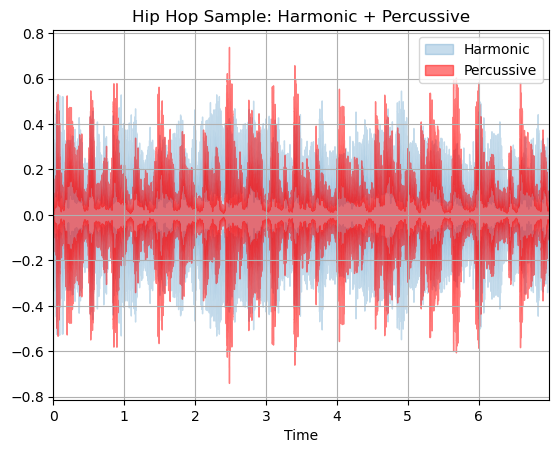

In [230]:
y2_harmonic, y2_percussive = librosa.effects.hpss(hiphop_sample)
plt.figure()
librosa.display.waveshow(y2_harmonic, sr=hiphop_sr, alpha=0.25, label = "Harmonic")
librosa.display.waveshow(y2_percussive, sr=hiphop_sr, color='r', alpha=0.5, label = "Percussive")
plt.title('Hip Hop Sample: Harmonic + Percussive')

plt.grid()
plt.legend()
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

#### Mean Value of Harmony and Rhythmic Components of Signal 

In [232]:
hop_length = 512;
n_fft = 2048;

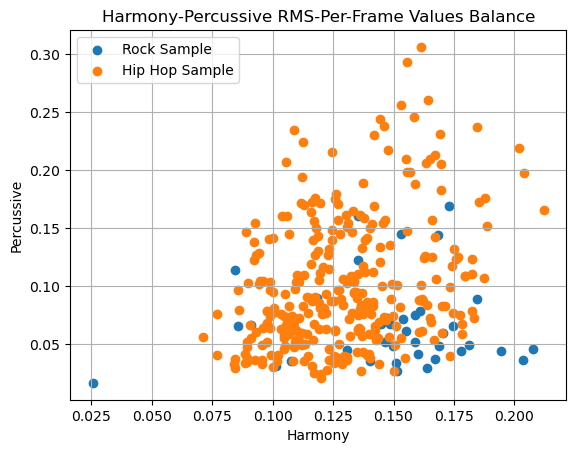

In [233]:
rock_harmony_rms = librosa.feature.rms(y=y1_harmonic,hop_length=8*hop_length)
rock_rhythmic_rms = librosa.feature.rms(y=y1_percussive,hop_length=8*hop_length)
plt.scatter(rock_harmony_rms,rock_rhythmic_rms, label = "Rock Sample")
plt.title("Harmony-Percussive RMS-Per-Frame Values Balance")
plt.xlabel("Harmony")
plt.ylabel("Percussive")


hiphop_harmony_rms = librosa.feature.rms(y=y2_harmonic)
hiphop_rhythmic_rms = librosa.feature.rms(y=y2_percussive)
plt.scatter(hiphop_harmony_rms,hiphop_rhythmic_rms,label = "Hip Hop Sample")
plt.legend()
plt.grid()
plt.show()

#### Chromagrams:

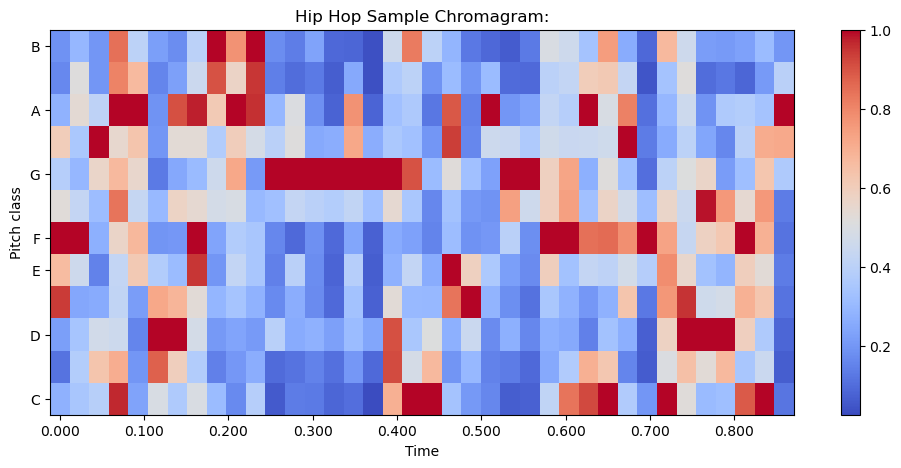

In [234]:
hiphop_chromagram = librosa.feature.chroma_stft(y=hiphop_sample, sr=hiphop_sr, hop_length=8*hop_length,n_fft=n_fft)

plt.figure(figsize=(12,5))
librosa.display.specshow(hiphop_chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.colorbar()
plt.title("Hip Hop Sample Chromagram:");

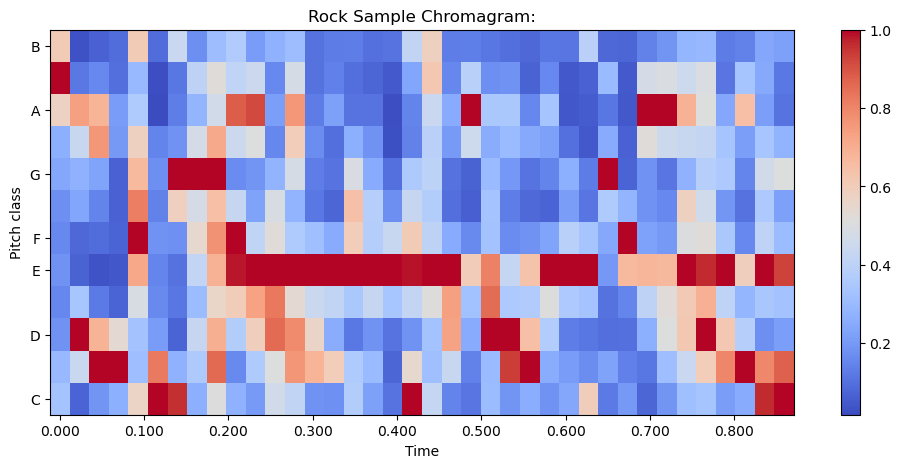

In [235]:
rock_chromagram = librosa.feature.chroma_stft(y=rock_sample, sr=rock_sr, hop_length=8*hop_length,n_fft=n_fft)

plt.figure(figsize=(12,5))
librosa.display.specshow(rock_chromagram, x_axis='time',y_axis = 'chroma',hop_length=hop_length, cmap='coolwarm')
plt.colorbar()
plt.title("Rock Sample Chromagram:");

We can also further investigate the mean and variance of the chromograms (in the actual data set, the mean and variance of the chromogram is calculated)

#### Calculate MFCC's:

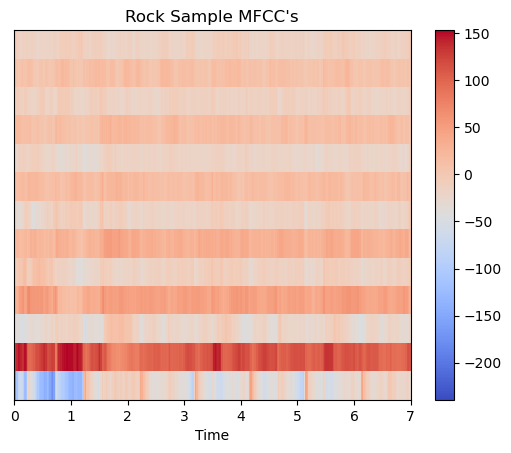

In [169]:
rock_sample_mfccs = librosa.feature.mfcc(y=rock_sample, sr=rock_sr, n_mfcc=13,hop_length=hop_length,n_fft=n_fft)
plt.figure()
librosa.display.specshow(rock_sample_mfccs, x_axis='time');
plt.colorbar()
plt.title("Rock Sample MFCC's");

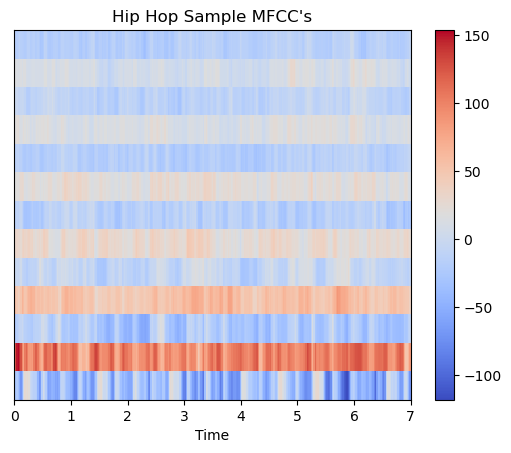

In [170]:
hiphop_sample_mfccs = librosa.feature.mfcc(y=hiphop_sample, sr=hiphop_sr, n_mfcc=13,hop_length=hop_length,n_fft=n_fft)
plt.figure()
librosa.display.specshow(hiphop_sample_mfccs, x_axis='time');
plt.colorbar()
plt.title("Hip Hop Sample MFCC's");

In [171]:
rock_sample_mfcc_mean = np.mean(rock_sample_mfccs,axis=1);
hiphop_sample_mfcc_mean = np.mean(hiphop_sample_mfccs,axis=1);

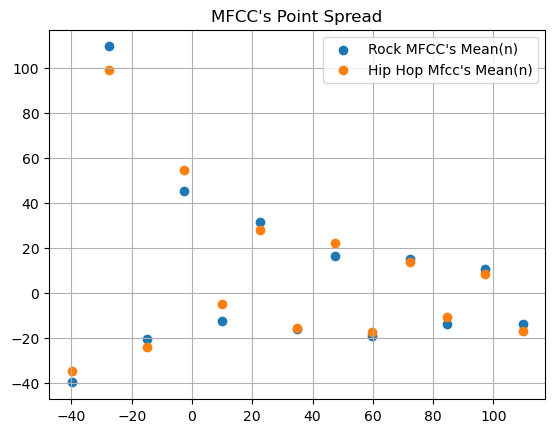

In [172]:
tmp = np.append(rock_sample_mfcc_mean,hiphop_sample_mfcc_mean);
lower_lim = min(tmp);
upper_lim = max(tmp);
x_ = np.linspace(lower_lim,upper_lim,len(rock_sample_mfcc_mean));
plt.scatter(x_,rock_sample_mfcc_mean,label = "Rock MFCC's Mean(n)");
plt.scatter(x_,hiphop_sample_mfcc_mean, label = "Hip Hop Mfcc's Mean(n)");

plt.title("MFCC's Point Spread")
plt.legend()
plt.grid()
plt.show()

#### Spectral Centroid:

In [196]:
rock_sample_spectral_cent = librosa.feature.spectral_centroid(y=rock_sample, sr=rock_sr,hop_length=hop_length,n_fft=n_fft).T
hiphop_sample_spectral_cent = librosa.feature.spectral_centroid(y=hiphop_sample, sr=hiphop_sr,hop_length=hop_length,n_fft=n_fft).T

In [197]:
rock_sample_spectral_cent_mean = rock_sample_spectral_cent.mean()
hiphop_sample_spectral_cent_mean = hiphop_sample_spectral_cent.mean()

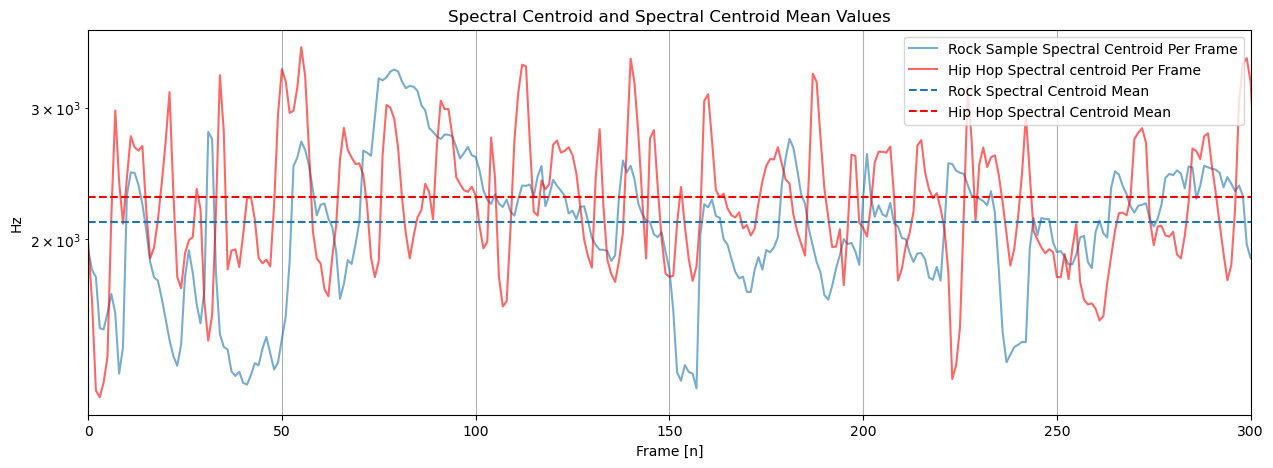

In [224]:
plt.figure(figsize=(15,5))
plt.semilogy(rock_sample_spectral_cent,alpha = 0.6, label='Rock Sample Spectral Centroid Per Frame')
plt.semilogy(hiphop_sample_spectral_cent,color="red",alpha = 0.6, label='Hip Hop Spectral centroid Per Frame')

plt.axhline(rock_sample_spectral_cent_mean, linestyle='--', label = "Rock Spectral Centroid Mean")
plt.axhline(hiphop_sample_spectral_cent_mean,color="red", linestyle='--', label = "Hip Hop Spectral Centroid Mean")

plt.xlim([0,300])
plt.ylabel("Hz");
plt.xlabel("Frame [n]");
plt.title("Spectral Centroid and Spectral Centroid Mean Values");
plt.legend();
plt.grid();

#### Spectral Rolloff:

In [225]:
rock_sample_spectral_rolloff = librosa.feature.spectral_rolloff(y=rock_sample, sr=rock_sr,hop_length=hop_length,n_fft=n_fft).T
hiphop_sample_spectral_rolloff = librosa.feature.spectral_rolloff(y=hiphop_sample, sr=hiphop_sr,hop_length=hop_length,n_fft=n_fft).T

In [226]:
rock_sample_spectral_rolloff_mean = rock_sample_spectral_rolloff.mean()
hiphop_sample_spectral_rolloff_mean = hiphop_sample_spectral_rolloff.mean()

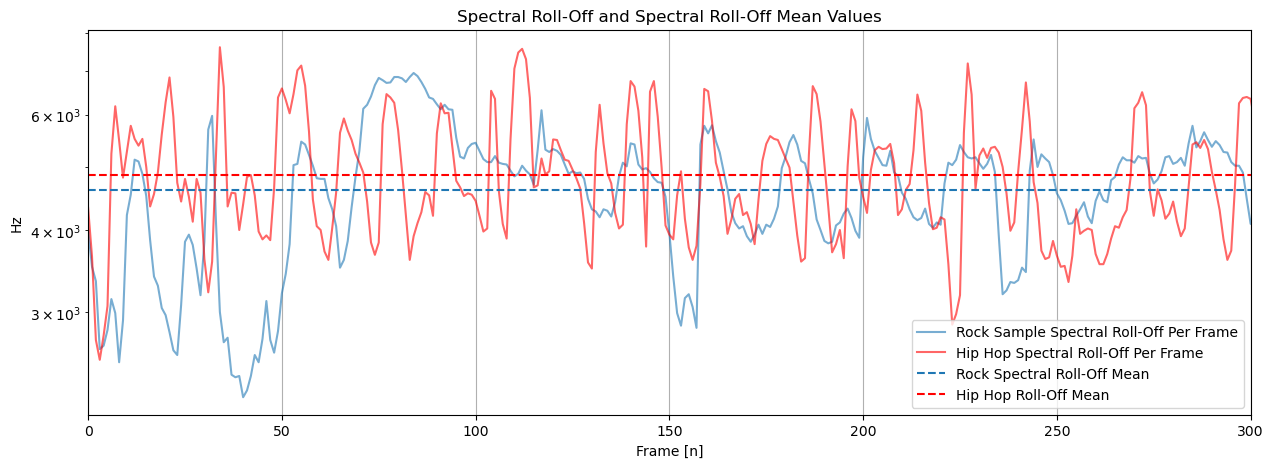

In [275]:
plt.figure(figsize=(15,5))
plt.semilogy(rock_sample_spectral_rolloff,alpha = 0.6, label='Rock Sample Spectral Roll-Off Per Frame')
plt.semilogy(hiphop_sample_spectral_rolloff,color="red",alpha = 0.6, label='Hip Hop Spectral Roll-Off Per Frame')

plt.axhline(rock_sample_spectral_rolloff_mean, linestyle='--', label = "Rock Spectral Roll-Off Mean")
plt.axhline(hiphop_sample_spectral_rolloff_mean,color="red", linestyle='--', label = "Hip Hop Roll-Off Mean")

plt.xlim([0,300])
plt.ylabel("Hz");
plt.xlabel("Frame [n]");
plt.title("Spectral Roll-Off and Spectral Roll-Off Mean Values");
plt.legend();
plt.grid();

#### Spectral Contrast:

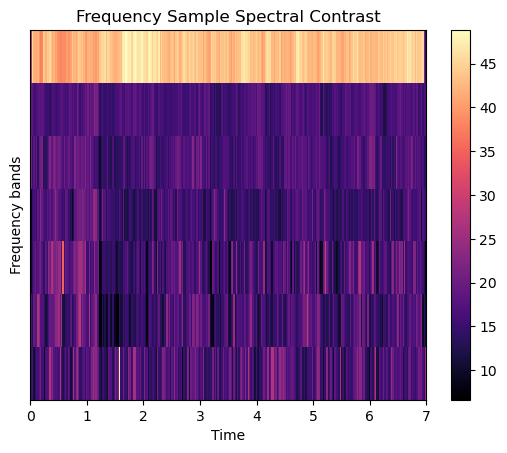

In [247]:
rock_sample_spectral_contrast=librosa.feature.spectral_contrast(y=rock_sample,sr=rock_sr,hop_length=hop_length,n_fft=n_fft);
plt.figure();
librosa.display.specshow(rock_sample_spectral_contrast, x_axis='time');
plt.colorbar();
plt.ylabel('Frequency bands');
plt.title('Frequency Sample Spectral Contrast');

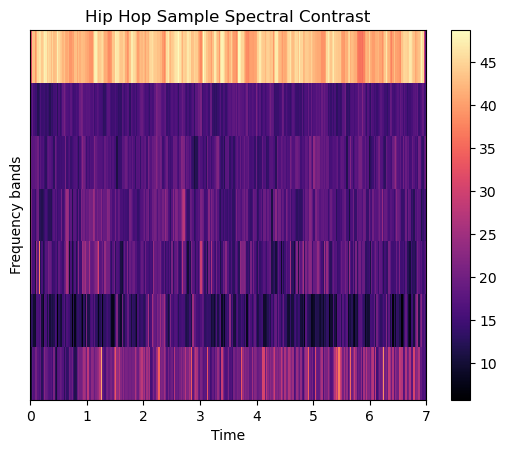

In [248]:
hiphop_sample_spectral_contrast=librosa.feature.spectral_contrast(y=hiphop_sample,sr=rock_sr,hop_length=hop_length,n_fft=n_fft);
plt.figure();
librosa.display.specshow(hiphop_sample_spectral_contrast, x_axis='time');
plt.colorbar();
plt.ylabel('Frequency bands');
plt.title('Hip Hop Sample Spectral Contrast');

In [250]:
rock_sample_spectral_contrast_mean = rock_sample_spectral_contrast.mean(axis=1)
hiphop_sample_spectral_contrast_mean = hiphop_sample_spectral_contrast.mean(axis=1)

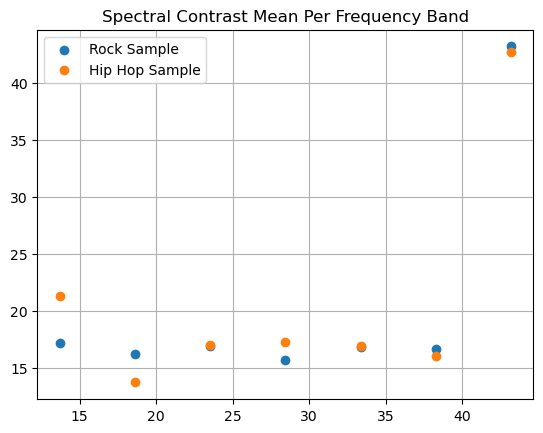

In [254]:
tmp = np.append(rock_sample_spectral_contrast_mean,hiphop_sample_spectral_contrast_mean);
lower_lim = min(tmp);
upper_lim = max(tmp);

x_ = np.linspace(lower_lim,upper_lim,len(rock_sample_spectral_contrast_mean));

plt.scatter(x_,rock_sample_spectral_contrast_mean,label="Rock Sample");
plt.scatter(x_,hiphop_sample_spectral_contrast_mean,label="Hip Hop Sample");
plt.grid();
plt.legend();
plt.title("Spectral Contrast Mean Per Frequency Band");

#### Zero Crossing Rate:

In [267]:
rock_sample_zrate=librosa.feature.zero_crossing_rate(rock_sample).T;
hiphop_sample_zrate=librosa.feature.zero_crossing_rate(hiphop_sample).T;

In [268]:
rock_sample_zero_crossing_rate_mean = rock_sample_zrate.mean()
hiphop_sample_zero_crossing_rate_mean = hiphop_sample_zrate.mean()

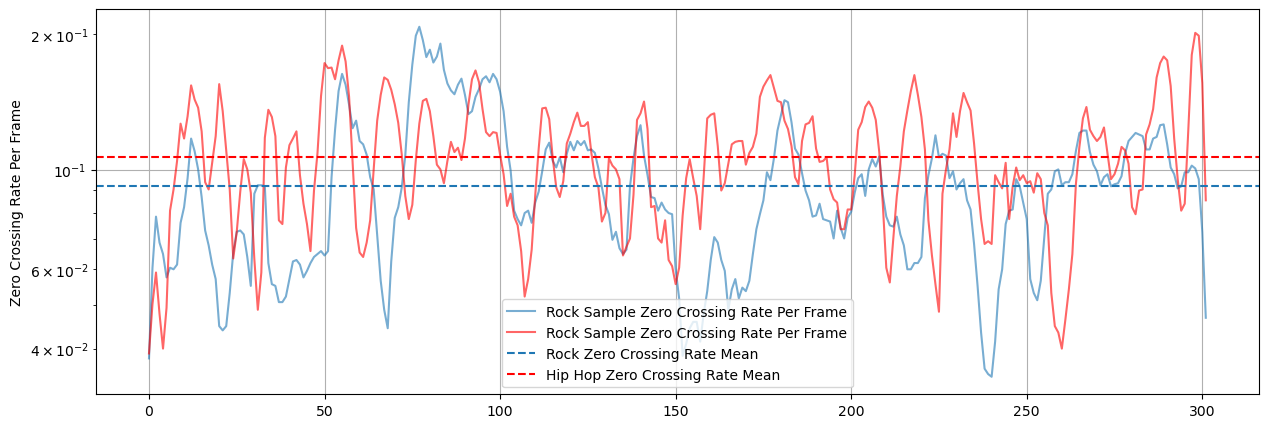

In [276]:
plt.figure(figsize=(15,5));
plt.semilogy(rock_sample_zrate,alpha=0.6,label="Rock Sample Zero Crossing Rate Per Frame");
plt.semilogy(hiphop_sample_zrate,alpha=0.6,color="red",label="Rock Sample Zero Crossing Rate Per Frame");
plt.ylabel('Zero Crossing Rate Per Frame');

plt.axhline(rock_sample_zero_crossing_rate_mean, linestyle='--', label = "Rock Zero Crossing Rate Mean")
plt.axhline(hiphop_sample_zero_crossing_rate_mean,color="red", linestyle='--', label = "Hip Hop Zero Crossing Rate Mean")

plt.grid();
plt.legend();

The data presented above is being calculated for each audio sample and store in a .csv file, among with the labeling of each sample.